# Predicting Activity with an LSTM
i.e., full dataset, transformed to PCA

In [1]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 66
numpy.random.seed(seed)

data = pandas.read_csv("../data/processed/train.csv")
notnull_data = data[data.notnull().all(axis=1)]
train = notnull_data.values
data2 = pandas.read_csv("../data/processed/test.csv")
notnull_data2 = data2[data2.notnull().all(axis=1)]
test = notnull_data2.values

Using Theano backend.


In [2]:
X_train = train[:,3:7558].astype(float)
#X_train = train[:,3:13].astype(float)
Y_train = train[:,7558]
X_test = test[:,3:7558].astype(float)
#X_test = test[:,3:13].astype(float)
Y_test = test[:,7558]

# One hot encoding of the response variable (using dummy variables)
from keras.utils.np_utils import to_categorical

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y_train = encoder.transform(Y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_Y_train)
encoder.fit(Y_test)
encoded_Y_test = encoder.transform(Y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = to_categorical(encoded_Y_test)

# Sanity check on matrix dimensions, after droppinig null/nans
print X_train.shape #(4472, 7555)
print Y_test.shape #(1044, )
print dummy_y_test.shape # (1044, 5)


(4472, 7555)
(1044,)
(1044, 5)


In [3]:
# We standardize on the basis of the training data
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

from sklearn import decomposition

pca = decomposition.PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_st)
X_test_pca = pca.transform(X_test_st)

print 'Variance explained:'
print pca.explained_variance_ratio_
print 'Total variance explained by 100 components:'
print sum(pca.explained_variance_ratio_)

Variance explained:
[ 0.19505564  0.08295663  0.04067402  0.02174272  0.01775119  0.01686748
  0.01440615  0.01150575  0.01055     0.00958828  0.00877439  0.00790115
  0.007298    0.00704889  0.0066142   0.00595329  0.00538577  0.00530285
  0.00491633  0.0045751   0.00440203  0.00436509  0.00395662  0.00343414
  0.00340722  0.00328142  0.00325585  0.00305899  0.00297009  0.00289683
  0.00281987  0.00273652  0.00266189  0.00265268  0.00260069  0.0024912
  0.00238337  0.00232648  0.00226495  0.00224082  0.00221907  0.00217391
  0.00215321  0.00208428  0.00204535  0.00198475  0.00192726  0.00190714
  0.00187787  0.00183914  0.00176811  0.00173735  0.00169542  0.00166308
  0.00165403  0.00162881  0.00161277  0.0015787   0.00157364  0.00155227
  0.0015123   0.00149719  0.00148685  0.00147954  0.00145035  0.00142099
  0.00141436  0.00141164  0.00138952  0.00136064  0.00134219  0.0013185
  0.00130973  0.00129871  0.00129763  0.0012655   0.00125215  0.00124378
  0.00122832  0.0012048   0.00119

In [4]:
from keras.layers import Dropout
from keras.layers import LSTM
from keras.constraints import maxnorm
from keras.optimizers import SGD

# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=7555, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(20, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout_decay():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.005, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_deeper_dropout_decay_PCA():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(100,)))
    model.add(Dense(300, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(300, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(80, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(80, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.8, decay=0.0001, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def create_LSTM_PCA(batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(20, batch_input_shape=(batch_size, 1, trainShape1), 
                   stateful=True))
    model.add(Dense(5, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_LSTM2_PCA(batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(200, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)

#model = create_baseline()
model = create_LSTM2_PCA()
print model.summary()

trainX = numpy.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
testX = numpy.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))
print trainX.shape




____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (1, 1, 200)           240800      lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (1, 1, 200)           0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (1, 1, 100)           120400      dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (1, 1, 100)           0           lstm_2[0][0]                     
___________________________________________________________________________________________

In [5]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("model--3lstm.json", "w") as json_file:
    json_file.write(model_json)
filepath="weights--3lstm.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


def printValStats(model, testX, dummy_y_test):
    # Other performance/accuracy metrics
    Y_pred = model.predict(testX, batch_size=batch_size)
    model.reset_states()
    print 'Performance of model on test set ----------------------------'
    # Accuracy
    print('Accuracy:')
    print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))
    # Confusion matrix
    cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
    numpy.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(cm)
    # AUC
    roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
    print('AUC score:')
    print(roc)


# Fit the model
batch_size = 1
nb_epochs = 30
accs =[]
val_accs =[]
losss =[]
val_losss =[]

# Manually create epochs and reset between sessions
for i in range(nb_epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', nb_epochs)
    #print trainX[0:5,:,:]
    #print dummy_y_train[0:5,:]
    history = model.fit(trainX, dummy_y_train, validation_data=(testX,dummy_y_test), 
                        nb_epoch=1, batch_size=batch_size, shuffle=False, 
                        verbose=1, callbacks=callbacks_list)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])

    model.reset_states()
    # Estimate model performance, and reset states!
    testScore = model.evaluate(testX, dummy_y_test, batch_size=batch_size, 
                                verbose=0)
    model.reset_states()
    print 'Test score after epoch of whole dataset:'
    print testScore
    printValStats(model, testX, dummy_y_test)

# Estimate model performance, and reset states!
testScore = model.evaluate(testX, dummy_y_test, batch_size=batch_size, 
                            verbose=0)
model.reset_states()
print 'Final Test score:'
print testScore

#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/




/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


('Epoch', 1, '/', 30)


WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 89s - loss: 1.3399 - acc: 0.4636 - val_loss: 1.5248 - val_acc: 0.4646
Test score after epoch of whole dataset:
[1.5246549441668265, 0.46455938697318006]
Performance of model on test set ----------------------------
Accuracy:
0.464559386973
Confusion matrix:
[[177  21   0   0   2]
 [ 17 308   0   0   0]
 [ 80 256   0   0   1]
 [ 44  51   0   0   0]
 [  6  81   0   0   0]]
AUC score:
0.714303131881
('Epoch', 2, '/', 30)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 95s - loss: 1.2417 - acc: 0.5049 - val_loss: 1.2808 - val_acc: 0.4780
Test score after epoch of whole dataset:
[1.2769349574243429, 0.47892720306513409]
Performance of model on test set ----------------------------
Accuracy:
0.478927203065
Confusion matrix:
[[186  14   0   0   0]
 [ 10 314   1   0   0]
 [ 79 258   0   0   0]
 [ 68  27   0   0   0]
 [  5  82   0   0   0]

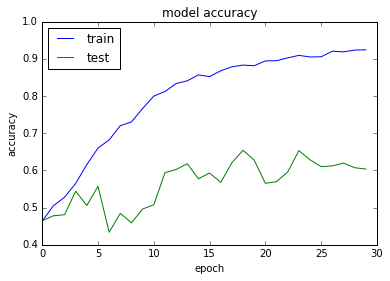

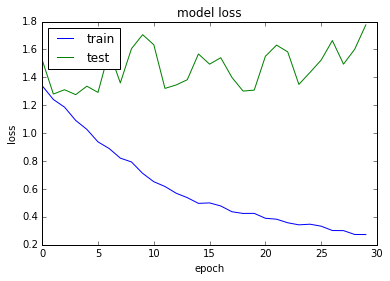

In [6]:
# summarize history for accuracy
plt.plot(accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(losss)
plt.plot(val_losss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [7]:
max(val_accs)

0.65421455938697315

# Similar LSTM, no dropout

In [8]:

def create_LSTM3_PCA_nodropout(batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(200, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(LSTM(100, 
                   return_sequences=True, stateful=True))
    model.add(LSTM(50, 
                   return_sequences=False, stateful=True))
    model.add(Dense(50, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)

#model = create_baseline()
model = create_LSTM3_PCA_nodropout()
print model.summary()

trainX = numpy.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
testX = numpy.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))
print trainX.shape




____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_4 (LSTM)                    (1, 1, 200)           240800      lstm_input_2[0][0]               
____________________________________________________________________________________________________
lstm_5 (LSTM)                    (1, 1, 100)           120400      lstm_4[0][0]                     
____________________________________________________________________________________________________
lstm_6 (LSTM)                    (1, 50)               30200       lstm_5[0][0]                     
____________________________________________________________________________________________________
dense_4 (Dense)                  (1, 50)               2550        lstm_6[0][0]                     
___________________________________________________________________________________________

In [9]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("model--3lstm--nodrop.json", "w") as json_file:
    json_file.write(model_json)
filepath="weights--3lstm--nodrop.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


def printValStats(model, testX, dummy_y_test):
    # Other performance/accuracy metrics
    Y_pred = model.predict(testX, batch_size=batch_size)
    model.reset_states()
    print 'Performance of model on test set ----------------------------'
    # Accuracy
    print('Accuracy:')
    print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))
    # Confusion matrix
    cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
    numpy.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(cm)
    # AUC
    roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
    print('AUC score:')
    print(roc)


# Fit the model
batch_size = 1
nb_epochs = 50
accs =[]
val_accs =[]
losss =[]
val_losss =[]

# Manually create epochs and reset between sessions
for i in range(nb_epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', nb_epochs)
    #print trainX[0:5,:,:]
    #print dummy_y_train[0:5,:]
    history = model.fit(trainX, dummy_y_train, validation_data=(testX,dummy_y_test), 
                        nb_epoch=1, batch_size=batch_size, shuffle=False, 
                        verbose=0, callbacks=callbacks_list)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])

    model.reset_states()
    # Estimate model performance, and reset states!
    testScore = model.evaluate(testX, dummy_y_test, batch_size=batch_size, 
                                verbose=0)
    model.reset_states()
    print 'Test score after epoch of whole dataset:'
    print testScore
    printValStats(model, testX, dummy_y_test)

# Estimate model performance, and reset states!
testScore = model.evaluate(testX, dummy_y_test, batch_size=batch_size, 
                            verbose=0)
model.reset_states()
print 'Final Test score:'
print testScore

#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/




('Epoch', 1, '/', 50)
Epoch 00000: val_acc improved from -inf to 0.31130, saving model to weights--3lstm--nodrop.best.hdf5
Test score after epoch of whole dataset:
[1.9004310343799919, 0.31130268199233718]
Performance of model on test set ----------------------------
Accuracy:
0.311302681992
Confusion matrix:
[[  0 196   4   0   0]
 [  0 325   0   0   0]
 [  0 283   0   0  54]
 [  0  95   0   0   0]
 [  0  87   0   0   0]]
AUC score:
0.520682318015
('Epoch', 2, '/', 50)
Epoch 00000: val_acc improved from 0.31130 to 0.47318, saving model to weights--3lstm--nodrop.best.hdf5
Test score after epoch of whole dataset:
[1.6002712563765003, 0.47222222222222221]
Performance of model on test set ----------------------------
Accuracy:
0.472222222222
Confusion matrix:
[[189  11   0   0   0]
 [ 21 304   0   0   0]
 [104 233   0   0   0]
 [ 63  32   0   0   0]
 [  8  79   0   0   0]]
AUC score:
0.696854913649
('Epoch', 3, '/', 50)
Epoch 00000: val_acc did not improve
Test score after epoch of whole 

24 0.612068965517


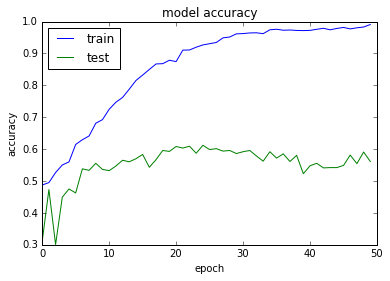

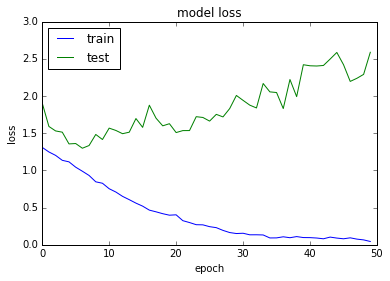

In [10]:
import operator
index, value = max(enumerate(val_accs), key=operator.itemgetter(1))
print index, value
# summarize history for accuracy
plt.plot(accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(losss)
plt.plot(val_losss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


**We don't get better performance by removing dropout**

# Bigger LSTM, more dropout


In [11]:

def create_LSTM3_PCA_dropmore(batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(400, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.4))
    model.add(LSTM(200, 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.4))
    model.add(LSTM(100, 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.4))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(40, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)

#model = create_baseline()
model = create_LSTM3_PCA_dropmore()
print model.summary()

trainX = numpy.reshape(X_train_pca, (X_train_pca.shape[0], 1, X_train_pca.shape[1]))
testX = numpy.reshape(X_test_pca, (X_test_pca.shape[0], 1, X_test_pca.shape[1]))
print trainX.shape




____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_7 (LSTM)                    (1, 1, 400)           801600      lstm_input_3[0][0]               
____________________________________________________________________________________________________
dropout_6 (Dropout)              (1, 1, 400)           0           lstm_7[0][0]                     
____________________________________________________________________________________________________
lstm_8 (LSTM)                    (1, 1, 200)           480800      dropout_6[0][0]                  
____________________________________________________________________________________________________
dropout_7 (Dropout)              (1, 1, 200)           0           lstm_8[0][0]                     
___________________________________________________________________________________________

In [12]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("model--3lstm--dropmore.json", "w") as json_file:
    json_file.write(model_json)
filepath="weights--3lstm--dropmore.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


def printValStats(model, testX, dummy_y_test):
    # Other performance/accuracy metrics
    Y_pred = model.predict(testX, batch_size=batch_size)
    model.reset_states()
    print 'Performance of model on test set ----------------------------'
    # Accuracy
    print('Accuracy:')
    print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))
    # Confusion matrix
    cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
    numpy.set_printoptions(precision=2)
    print('Confusion matrix:')
    print(cm)
    # AUC
    roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
    print('AUC score:')
    print(roc)


# Fit the model
batch_size = 1
nb_epochs = 50
accs =[]
val_accs =[]
losss =[]
val_losss =[]

# Manually create epochs and reset between sessions
for i in range(nb_epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', nb_epochs)
    #print trainX[0:5,:,:]
    #print dummy_y_train[0:5,:]
    history = model.fit(trainX, dummy_y_train, validation_data=(testX,dummy_y_test), 
                        nb_epoch=1, batch_size=batch_size, shuffle=False, 
                        verbose=1, callbacks=callbacks_list)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])

    model.reset_states()
    # Estimate model performance, and reset states!
    testScore = model.evaluate(testX, dummy_y_test, batch_size=batch_size, 
                                verbose=0)
    model.reset_states()
    printValStats(model, testX, dummy_y_test)

import operator
index, value = max(enumerate(val_accs), key=operator.itemgetter(1))
print index, value

#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

# summarize history for accuracy
plt.plot(accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(losss)
plt.plot(val_losss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


('Epoch', 1, '/', 50)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 197s - loss: 1.4637 - acc: 0.4390 - val_loss: 2.0324 - val_acc: 0.2989
Performance of model on test set ----------------------------
Accuracy:
0.311302681992
Confusion matrix:
[[  0 200   0   0   0]
 [  0 325   0   0   0]
 [  0 272   0   0  65]
 [  0  95   0   0   0]
 [  0  87   0   0   0]]
AUC score:
0.534061005574
('Epoch', 2, '/', 50)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [==============================] - 253s - loss: 1.3513 - acc: 0.4492 - val_loss: 2.0450 - val_acc: 0.1724
Performance of model on test set ----------------------------
Accuracy:
0.205938697318
Confusion matrix:
[[  0 199   0   0   1]
 [  0 203   0   0 122]
 [  0 265   0   0  72]
 [  0  93   0   0   2]
 [  0  75   0   0  12]]
AUC score:
0.507237924475
('Epoch', 3, '/', 50)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
4472/4472 [=======================

KeyboardInterrupt: 

21 0.611111111111


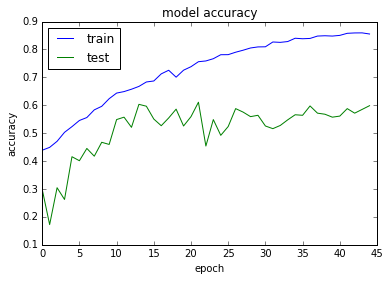

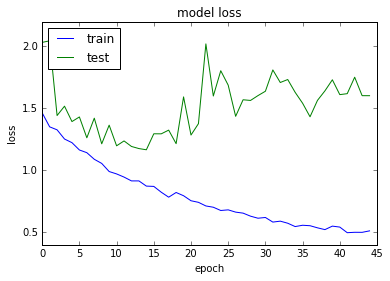

In [13]:
import operator
index, value = max(enumerate(val_accs), key=operator.itemgetter(1))
print index, value

#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/

# summarize history for accuracy
plt.plot(accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(losss)
plt.plot(val_losss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


# LSTM with all 7000+ features

In [14]:
def create_LSTM3(batch_size = 1, trainShape1=100):
    # create and fit the LSTM network
    model = Sequential()
    # stateful LSTM!
    model.add(LSTM(200, batch_input_shape=(batch_size, 1, trainShape1), 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, 
                   return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, 
                   return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)

#model = create_baseline()
model = create_LSTM3(batch_size=1, trainShape1=X_train_st.shape[1])
print model.summary()

trainX = numpy.reshape(X_train_st, (X_train_st.shape[0], 1, X_train_st.shape[1]))
testX = numpy.reshape(X_test_st, (X_test_st.shape[0], 1, X_test_st.shape[1]))
print trainX.shape

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_10 (LSTM)                   (1, 1, 200)           6204800     lstm_input_4[0][0]               
____________________________________________________________________________________________________
dropout_11 (Dropout)             (1, 1, 200)           0           lstm_10[0][0]                    
____________________________________________________________________________________________________
lstm_11 (LSTM)                   (1, 1, 100)           120400      dropout_11[0][0]                 
____________________________________________________________________________________________________
dropout_12 (Dropout)             (1, 1, 100)           0           lstm_11[0][0]                    
___________________________________________________________________________________________

In [ ]:
# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("model--3lstm--allfeat.json", "w") as json_file:
    json_file.write(model_json)
filepath="weights--3lstm--allfeat.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
batch_size = 1
nb_epochs = 25
accs =[]
val_accs =[]
losss =[]
val_losss =[]

# Manually create epochs and reset between sessions
for i in range(nb_epochs):
    # Single epoch. Remember to not shuffle the data!
    print('Epoch', i+1, '/', nb_epochs)
    #print trainX[0:5,:,:]
    #print dummy_y_train[0:5,:]
    history = model.fit(trainX, dummy_y_train, validation_data=(testX,dummy_y_test), 
                        nb_epoch=1, batch_size=batch_size, shuffle=False, 
                        verbose=1, callbacks=callbacks_list)
    accs.append(history.history['acc'][0])
    val_accs.append(history.history['val_acc'][0])
    losss.append(history.history['loss'][0])
    val_losss.append(history.history['val_loss'][0])

    model.reset_states()
    # Estimate model performance, and reset states!
    printValStats(model, testX, dummy_y_test)

import operator
index, value = max(enumerate(val_accs), key=operator.itemgetter(1))
print index, value

# summarize history for accuracy
plt.plot(accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(losss)
plt.plot(val_losss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

('Epoch', 1, '/', 2)
Train on 4472 samples, validate on 1044 samples
Epoch 1/1
 673/4472 [===>..........................] - ETA: 540s - loss: 1.6709 - acc: 0.3254

# Try the best LSTM with Social too

# Do a combined ActivitySocial prediction too